#### **Exploring the profiles characteristics and relationship with environmental variables.**

The following cells will evaluate the profiles characteristics by computing the distribution of psychopathology in each profile and evaluating the relationship with environmental factors.

In [1]:
# Imports
import os
from itertools import product

from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore, false_discovery_control
from sklearn.preprocessing import scale

from neurostatx.network.utils import (fetch_attributes_df, fetch_edge_data)
from neurostatx.utils.preprocessing import merge_dataframes
from neurostatx.io.utils import load_df_in_any_format
from neurostatx.statistics.models import plsr_cv, permutation_testing
from neurostatx.io.viz import generate_coef_plot

In [2]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# Setting up relevant paths.
repository_path = "/Users/anthonygagnon/code/Article-s-Code/" # CHANGE THIS
abcd_base_path = "/Volumes/T7/CCPM/ABCD/Release_5.1/abcd-data-release-5.1/" # CHANGE THIS
geste_base_dir = "/Volumes/T7/CCPM/GESTE/" # CHANGE THIS
banda_dir = '/Volumes/T7/CCPM/BANDA/BANDARelease1.1/' # CHANGE THIS
output_folder = "/Volumes/T7/CCPM/RESULTS_JUNE_24/" # CHANGE THIS
data_dir = f"{output_folder}/fuzzyclustering/"
output_dir = f"{output_folder}/profileanalysis/"

# Create output directory if it does not exist.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
# Useful functions
def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(x=angle,
                y=value + padding,
                s=label,
                ha=alignment,
                va='center',
                rotation=rotation,
                rotation_mode='anchor')

#### **Counting the number of subject with a psychopathology in each profile using data from all cohorts.**

The following section will count the number of participants with a psychopathology diagnosis in each profile using data from all studies. Results will be reported using a barplot as seen in Gagnon et al..

**In order to count participants with a psychopathology in each profile, membership values are transformed into discrete labels. To do so, the highest membership value is taken as the main profile.**

In [5]:
# Loading graph from file.
G = nx.read_gml(f'{data_dir}/GraphNetwork.gml')

In [6]:
# Fetching attributes and edges data.
attributes_df = fetch_attributes_df(G, attributes='')
edges_df = fetch_edge_data(G)

In [7]:
# Fetching highest membership value for each node.
attributes_df.loc[:, 'profiles'] = np.argmax(edges_df.values, axis=1) + 1

In [8]:
# Count the number of subject per profiles.
profiles_count = attributes_df['profiles'].value_counts()
profiles_count

profiles
3    4032
4    3730
1    1896
2    1651
Name: count, dtype: int64

#### **Counting the number of participants with a diagnosis in each profile within the ABCD cohort.**

In order to have comparable results between studies, we computed the percentage of each disorder (compared to the total number of participants with this specific disorder) for each profile. For example, the resulting value indicates that the profile X contains XX% of the participants with an ADHD diagnosis. Doing by diagnosis also diminishes the impact of comorbidities, since multiple participants have more than one diagnosis. 

In [32]:
# Extracting only abcd participants.
abcd_df = attributes_df[attributes_df['cohort'] == 1]

In [33]:
# Computing percentage for the abcd dataset.
abcd_perc = []
for dx in ['AD', 'ADHD', 'CD', 'DD', 'OCD', 'ODD']:
    for profile in np.unique(abcd_df[['profiles']]):
        profile_df = abcd_df[abcd_df['profiles'] == profile]
        abcd_perc.append(profile_df[profile_df.loc[:, dx] == 1][dx].sum() / abcd_df[dx].sum() * 100)

In [34]:
# Setting the DataFrame vertically
abcd_perc_v = pd.DataFrame(np.array(abcd_perc),
                    columns=['values'],
                    index=['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)'] * 6)
abcd_perc_v['group'] = np.repeat(['AD', 'ADHD', 'CD', 'DD', 'OCD', 'ODD'], 4)
abcd_perc_v['cohort'] = 'ABCD'

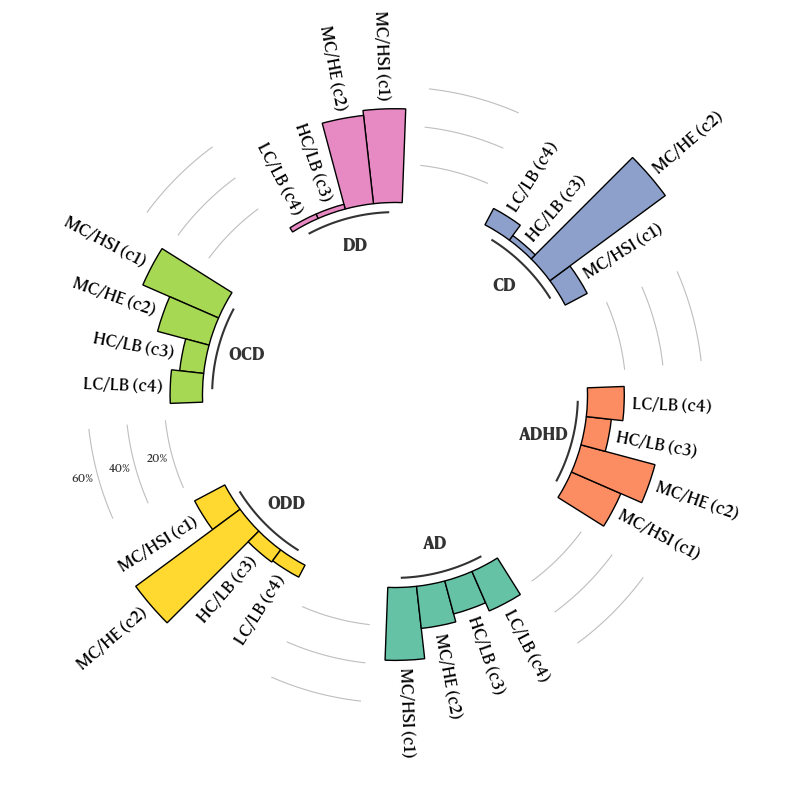

In [36]:
# Has to be defined for each plot, as the angle is different.
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle >= np.pi:
        alignment = 'right'
        rotation = rotation + 180
    else:
        alignment = 'left'
        rotation = rotation 
    return rotation, alignment

# Circular barplot.
values=abcd_perc_v['values'].values
labels=abcd_perc_v.index
group = abcd_perc_v['group'].values

# Create space between clusters.
pad = 3
angles_n = len(values) + pad * len(np.unique(group))
angles = np.linspace(0, 2 * np.pi, num=angles_n, endpoint=False)

# Set the width of each bar + offset for the first one.
width = 2 * np.pi / len(angles)
offset = 0

# Getting the size of each group.
group_size = [len(i[1]) for i in abcd_perc_v.groupby('group')]
idxs = []
for size in group_size:
    idxs += list(range(offset + pad, offset + size + pad))
    offset += size + pad

# Create the figure and the axis.
with plt.rc_context(
        {"font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         "font.family": "Harding Text Web"}
    ):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(offset)
    ax.set_frame_on(False)

    # Set limits.
    ax.set_ylim(-100, 100)

    # Remove grid and tick marks.
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    # Set colors
    colors = sns.color_palette("Set2", n_colors=7)
    color = [colors[i] for i, size in enumerate(group_size) for _ in range(size)]

    # Plot the bars.
    ax.bar(angles[idxs], values, width=width, linewidth=1, color=color, edgecolor="black")

    # Add labels.
    add_labels(angles[idxs], values, labels, offset, ax)

    # Adding reference lines and group indicators.
    offset = 0
    for group, size in zip(np.unique(abcd_perc_v['group'].values), group_size):
        x1 = np.linspace(angles[offset + pad], angles[offset + size + pad - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")

        # add group indicators.
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=12,
            fontweight="bold", ha="center", va="center"
        )

        # Add reference lines.
        x2 = np.linspace(angles[offset], angles[offset + pad - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)

        offset += size + pad

    # Add label to single reference bar. 
    ax.text(
        np.mean(x2), 68, '60%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 48, '40%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 28, '20%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )

    plt.savefig(f'{output_dir}/circular_ABCD_dx.png', dpi=900)
    plt.show()


#### **Counting the number of participants with a diagnosis in each profile within the BANDA cohort.**

In order to have comparable results between studies, we computed the percentage of each disorder (compared to the total number of participants with this specific disorder) for each profile. For example, the resulting value indicates that the profile X contains XX% of the participants with an ADHD diagnosis. Doing by diagnosis also diminishes the impact of comorbidities, since multiple participants have more than one diagnosis. 

In [37]:
banda_df = attributes_df[attributes_df['cohort'] == 2]

# Print the number of participants per profile.
banda_df['profiles'].value_counts()

profiles
3    59
4    55
1    47
2    34
Name: count, dtype: int64

In [38]:
# Computing percentage for the BANDA dataset.
banda_perc = []
for dx in ['AD', 'ADHD', 'DD', 'OCD', 'ODD']:
    for profile in np.unique(banda_df[['profiles']]):
        profile_df = banda_df[banda_df['profiles'] == profile]
        banda_perc.append(profile_df[profile_df.loc[:, dx] == 1][dx].sum() / banda_df[dx].sum() * 100)

In [39]:
# Setting the DataFrame vertically
banda_perc_v = pd.DataFrame(np.array(banda_perc),
                    columns=['values'],
                    index=['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)'] * 5)
banda_perc_v['group'] = np.repeat(['AD', 'ADHD', 'DD', 'OCD', 'ODD'], 4)
banda_perc_v['cohort'] = 'BANDA'

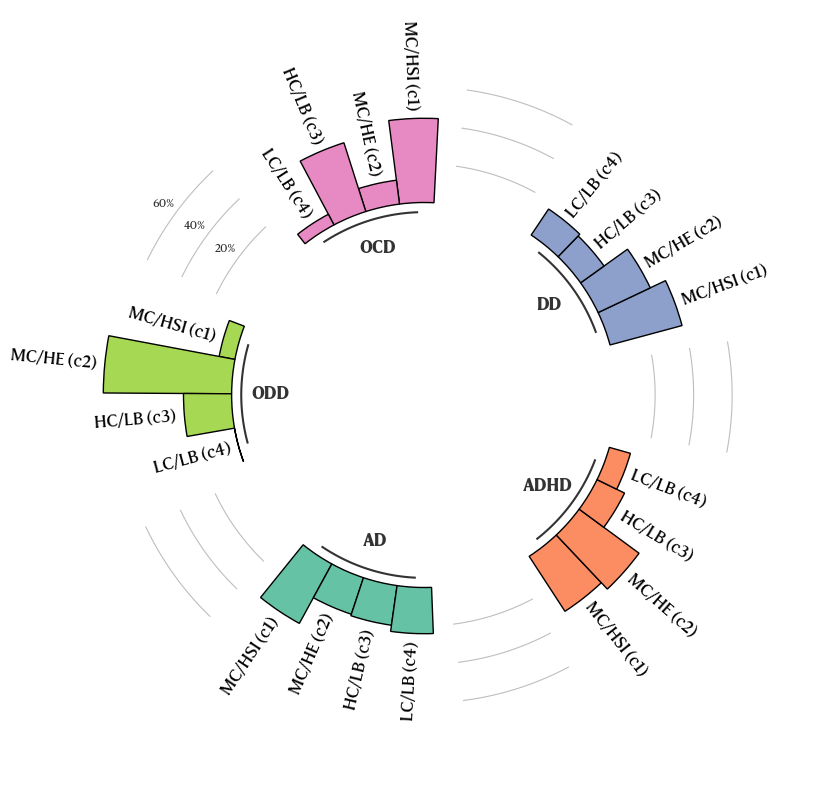

In [40]:
# Has to be defined for each plot, as the angle is different.
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi / 2.2 or angle >= 3 * np.pi / 2.2:
        alignment = 'right'
        rotation = rotation + 180
    else:
        alignment = 'left'
        rotation = rotation 
    return rotation, alignment

# Circular barplot.
values=banda_perc_v['values'].values
labels=banda_perc_v.index
group = banda_perc_v['group'].values

# Create space between clusters.
pad = 3
angles_n = len(values) + pad * len(np.unique(group))
angles = np.linspace(0, 2 * np.pi, num=angles_n, endpoint=False)

# Set the width of each bar + offset for the first one.
width = 2 * np.pi / len(angles)
offset = 0

# Getting the size of each group.
group_size = [len(i[1]) for i in banda_perc_v.groupby('group')]
idxs = []
for size in group_size:
    idxs += list(range(offset + pad, offset + size + pad))
    offset += size + pad

# Create the figure and the axis.
with plt.rc_context(
        {"font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         "font.family": "Harding Text Web"}
    ):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(offset)
    ax.set_frame_on(False)

    # Set limits.
    ax.set_ylim(-100, 100)

    # Remove grid and tick marks.
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    # Set colors
    colors = sns.color_palette("Set2", n_colors=7)
    color = [colors[i] for i, size in enumerate(group_size) for _ in range(size)]

    # Plot the bars.
    ax.bar(angles[idxs], values, width=width, linewidth=1, color=color, edgecolor="black")

    # Add labels.
    add_labels(angles[idxs], values, labels, offset, ax)

    # Adding reference lines and group indicators.
    offset = 0
    for group, size in zip(np.unique(banda_perc_v['group'].values), group_size):
        x1 = np.linspace(angles[offset + pad], angles[offset + size + pad - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")

        # add group indicators.
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=12,
            fontweight="bold", ha="center", va="center"
        )

        # Add reference lines.
        x2 = np.linspace(angles[offset], angles[offset + pad - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)

        offset += size + pad

    # Add label to single reference bar. 
    ax.text(
        np.mean(x2), 68, '60%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 48, '40%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 28, '20%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )

    plt.savefig(f'{output_dir}/circular_BANDA_dx.png', dpi=900)
    plt.show()


#### **Counting the number of participants with a diagnosis in each profile within the GESTE cohort.**

In order to have comparable results between studies, we computed the percentage of each disorder (compared to the total number of participants with this specific disorder) for each profile. For example, the resulting value indicates that the profile X contains XX% of the participants with an ADHD diagnosis. Doing by diagnosis also diminishes the impact of comorbidities, since multiple participants have more than one diagnosis. 

In [41]:
geste_df = attributes_df[attributes_df['cohort'] == 3]

# Print the number of participants per profile.
geste_df['profiles'].value_counts()

profiles
4    83
3    77
1    58
2    53
Name: count, dtype: int64

In [42]:
# Computing percentage for the GESTE dataset.
geste_perc = []
for dx in ['ADHD']:
    for profile in np.unique(geste_df[['profiles']]):
        profile_df = geste_df[geste_df['profiles'] == profile]
        geste_perc.append(profile_df[profile_df.loc[:, dx] == 1][dx].sum() / geste_df[dx].sum() * 100)

In [43]:
# Setting the DataFrame vertically
geste_perc_v = pd.DataFrame(np.array(geste_perc),
                    columns=['values'],
                    index=['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)'] * 1)
geste_perc_v['group'] = np.repeat(['ADHD'], 4)
geste_perc_v['cohort'] = 'GESTE'

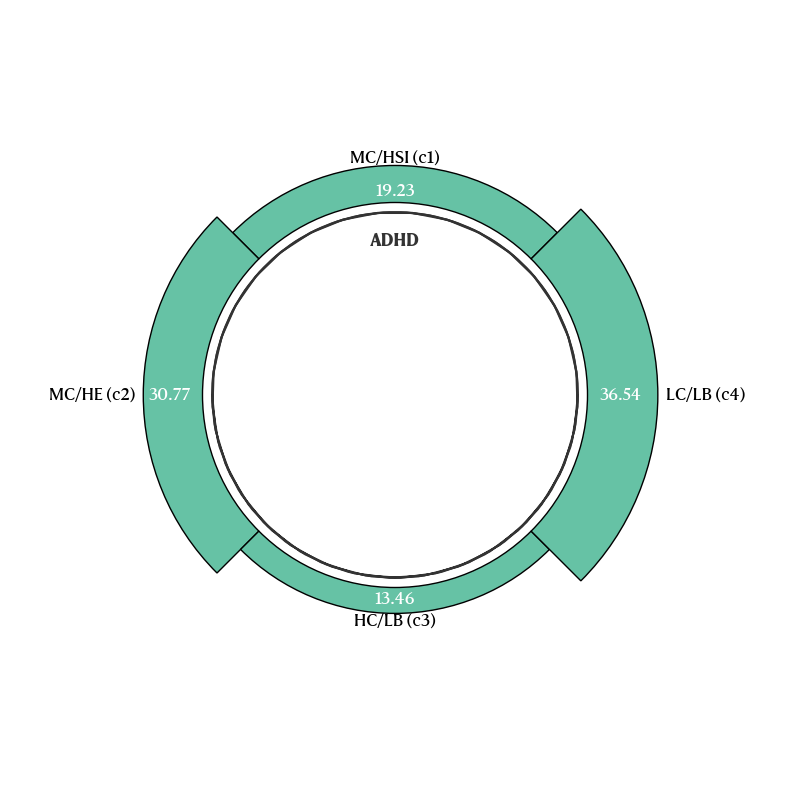

In [44]:
# Has to be defined for each plot, as the angle is different.
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle == np.pi:
        alignment = "center"
        rotation = rotation + 90
    elif angle == 0:
        alignment = 'center'
        rotation = rotation - 90
    elif angle == np.pi / 2:
        alignment = 'right'
        rotation = rotation + 180
    else:
        alignment = 'left'
        rotation = rotation 
    return rotation, alignment

# Circular barplot.
values=geste_perc_v['values'].values
labels=geste_perc_v.index
group = geste_perc_v['group'].values

# Create space between clusters.
pad = 3
angles = np.linspace(0, 2 * np.pi, num=len(geste_perc_v), endpoint=False)

# Set the width of each bar + offset for the first one.
width = 2 * np.pi / len(angles)
offset = np.pi / 2 

# Create the figure and the axis.
with plt.rc_context(
        {"font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         "font.family": "Harding Text Web"}
    ):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(offset)
    ax.set_frame_on(False)

    # Set limits.
    ax.set_ylim(-100, 100)

    # Remove grid and tick marks.
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    # Set colors
    colors = sns.color_palette("Set2", n_colors=7)
    color = [colors[i] for i, size in enumerate(group_size) for _ in range(size)]

    # Plot the bars.
    ax.bar(angles, values, width=width, linewidth=1, color=color, edgecolor="black")

    # Add labels.
    add_labels(angles, values, labels, offset, ax)

    # Adding reference lines and group indicators.
    offset = 0
    for group, size in zip(np.unique(geste_perc_v['group'].values), group_size):
        x1 = np.linspace(angles, -angles, num=50)
        ax.plot(x1, [-5] * 50, color="#333333")

        # add group indicators.
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=12,
            fontweight="bold", ha="center", va="center"
        )

    for angle, value in zip(angles, values):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(x=angle,
                y=6,
                s=np.round(value, 2),
                ha=alignment,
                va='center',
                color='white',
                rotation=rotation + 90,
                rotation_mode='anchor')

    plt.savefig(f'{output_dir}/circular_GESTE_dx.png', dpi=900)
    plt.show()


#### **Visualizing percentage from each cohort in the same barplot.**

The next cells will combined psychopathology percentage from all cohorts into a single bar plot.

In [25]:
# Merging all dataframes together.
all_vert = pd.concat([abcd_perc_v, banda_perc_v, geste_perc_v], axis=0)
all_vert.sort_values(by=["group", 'cohort'], inplace=True)

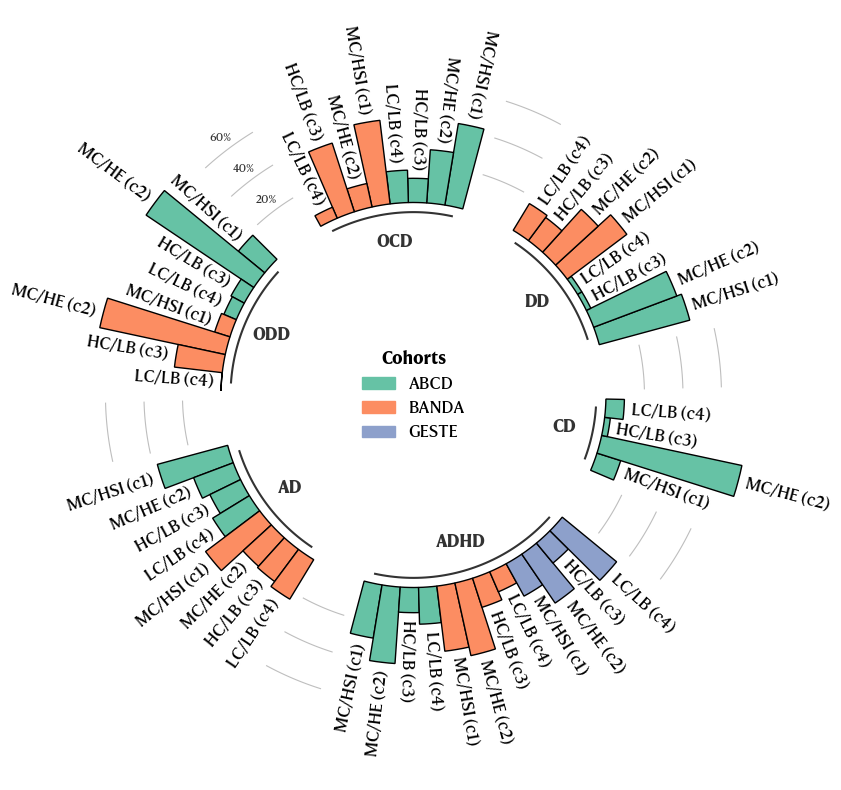

In [40]:
# Has to be defined for each plot, as the angle is different.
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi / 2.2 or angle >= 3 * np.pi / 2.2:
        alignment = 'right'
        rotation = rotation + 180
    else:
        alignment = 'left'
        rotation = rotation 
    return rotation, alignment

# Circular barplot.
values=all_vert['values'].values
labels=all_vert.index
group = all_vert['group'].values

# Create space between clusters.
pad = 3
angles_n = len(values) + pad * len(np.unique(group))
angles = np.linspace(0, 2 * np.pi, num=angles_n, endpoint=False)

# Set the width of each bar + offset for the first one.
width = 2 * np.pi / len(angles)
offset = 0

# Getting the size of each group.
group_size = [len(i[1]) for i in all_vert.groupby('group')]
idxs = []
for size in group_size:
    idxs += list(range(offset + pad, offset + size + pad))
    offset += size + pad

# Create the figure and the axis.
with plt.rc_context(
        {"font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         "font.family": "Harding Text Web"}
    ):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(offset)
    ax.set_frame_on(False)

    # Set limits.
    ax.set_ylim(-100, 100)

    # Remove grid and tick marks.
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    # Set colors
    colors = sns.color_palette("Set2", n_colors=4)
    color = []
    for i in all_vert["cohort"]:
        if i == "ABCD":
            color.append(colors[0])
        elif i == "BANDA":
            color.append(colors[1])
        else:
            color.append(colors[2])

    # Plot the bars.
    ax.bar(angles[idxs], values, width=width, linewidth=1, color=color, edgecolor="black")

    # Add labels.
    add_labels(angles[idxs], values, labels, offset, ax)

    # Adding reference lines and group indicators.
    offset = 0
    for group, size in zip(np.unique(all_vert['group'].values), group_size):
        x1 = np.linspace(angles[offset + pad], angles[offset + size + pad - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")

        # add group indicators.
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=12,
            fontweight="bold", ha="center", va="center"
        )

        # Add reference lines.
        x2 = np.linspace(angles[offset], angles[offset + pad - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)

        offset += size + pad

    # Add label to single reference bar. 
    ax.text(
        np.mean(x2), 67, '60%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 47, '40%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 27, '20%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )

    abcd_patch = mpatches.Patch(color=colors[0], label='ABCD')
    banda_patch = mpatches.Patch(color=colors[1], label='BANDA')
    geste_patch = mpatches.Patch(color=colors[2], label='GESTE')
    ax.legend(handles=[abcd_patch, banda_patch, geste_patch], loc='center',
            bbox_to_anchor=(0.5, 0.5), title='Cohorts',
            frameon=False, fontsize=12,
            title_fontproperties={"weight": "bold", "size": 12})

    plt.savefig(f'{output_dir}/circular_barplot_all.png', dpi=900)
    plt.show()

#### **Exploring community/parental/environmental factors and their relationship with the cognitive/behavioral profiles.**

The next cells will evaluate the relationship between environmental factors and the fuzzy cognitive/behavioral profiles within the ABCD study (replication in the GESTE study is also available further below). **Here is the list of all included variables from the ABCD study:**

Youth Report:
1. Report of Parental Behavioral Inventory (ce_y_crpbi)
1. Parental Monitoring (ce_y_pm)
1. Family Environment Scale (ce_y_fes)
1. School Risk and Protective Factors (ce_y_srpf)

Parent Report:
1. Neighborhood Safety (ce_p_nsc)
1. Food Insecurity (abcd_p_demo)
1. Ability to pay bills (abcd_p_demo)
1. Ability to pay for housing (abcd_p_demo)
1. Ability to pay for medical care (abcd_p_demo)
1. History of traumatic events (mh_p_ksads_ss)
1. Total prenatal conditions (ph_p_dhx)
1. Total prenatal drugs (ph_p_dhx)
1. Gestational Age (ph_p_dhx)
1. Birth Weight (ph_p_dhx)
1. Planned Pregnancy (ph_p_dhx)
1. Maternal Age at delivery (ph_p_dhx)
1. Parental Psychopathology (mh_p_asr and mh_p_fhx)
1. Sleeping Hours (ph_p_sds)

Some of the variables have been encoded/aggregated to facilitate the analysis. You can find the applied operations in the small helper functions the cells below. **Running the PLSR analysis on the ABCD data takes quite some time! If possible, multithreading the code will help. You can select the number of processes to use by changing the `processes=` argument in the PLSR-related functions.**

In [9]:
# Economic measures.
economic_df = load_df_in_any_format(f'{abcd_base_path}/core/abcd-general/abcd_p_demo.csv')
economic_df = economic_df.loc[economic_df.eventname == 'baseline_year_1_arm_1']
economic_df = economic_df[['src_subject_id', 'demo_fam_exp1_v2', 'demo_fam_exp2_v2', 'demo_fam_exp5_v2',
                           'demo_fam_exp3_v2', 'demo_fam_exp4_v2', 'demo_fam_exp6_v2', 'demo_fam_exp7_v2',
                           'demo_prnt_prtnr_v2']]
economic_df.reset_index(drop=True, inplace=True)

# Replace 777 (refuse to answer) by NaNs.
economic_df.replace(777, np.nan, inplace=True)

# Helper functions to recode some of the economic measures.
def recode_bills(row):
    if row.demo_fam_exp2_v2 == 1 or row.demo_fam_exp5_v2 == 1:
        return 1
    elif row.demo_fam_exp2_v2 == 0 and row.demo_fam_exp5_v2 == 0:
        return 0
    else:
        ValueError("Unexpected value in the row.")

def recode_housing(row):
    if row.demo_fam_exp3_v2 == 1 or row.demo_fam_exp4_v2 == 1:
        return 1
    elif row.demo_fam_exp3_v2 == 0 and row.demo_fam_exp4_v2 == 0:
        return 0
    else:
        ValueError("Unexpected value in the row.")

def recode_medical(row):
    if row.demo_fam_exp6_v2 == 1 or row.demo_fam_exp7_v2 == 1:
        return 1
    elif row.demo_fam_exp6_v2 == 0 and row.demo_fam_exp7_v2 == 0:
        return 0
    else:
        ValueError("Unexpected value in the row.")

# Recoding economic measures.
economic_df.loc[:, 'bills'] = economic_df.apply(recode_bills, axis=1)
economic_df.loc[:, 'housing'] = economic_df.apply(recode_housing, axis=1)
economic_df.loc[:, 'medical'] = economic_df.apply(recode_medical, axis=1)

# Drop columns and reset index.
economic_df = economic_df[['src_subject_id', 'demo_fam_exp1_v2', 'bills', 'housing', 'medical']]
economic_df.columns = ['subjectkey', 'FoodInsecurity', 'Bills', 'Housing', 'Medical']

# Traumatic events.
trauma_df = load_df_in_any_format(f'{abcd_base_path}/core/mental-health/mh_p_ksads_ss.csv')
trauma_df = trauma_df.loc[trauma_df.eventname == 'baseline_year_1_arm_1']
trauma_df = trauma_df[['src_subject_id', 'ksads_21_134_p']]
trauma_df.columns = ['subjectkey', 'TraumaticEvents']
trauma_df.reset_index(drop=True, inplace=True)

# Parental psychopathology.
parent_psychopatho_df = load_df_in_any_format(f'{abcd_base_path}/core/mental-health/mh_p_asr.csv')
parent_psychopatho_df = parent_psychopatho_df.loc[parent_psychopatho_df.eventname == 'baseline_year_1_arm_1']
parent_psychopatho_df = parent_psychopatho_df[['src_subject_id', 'asr_scr_totprob_t']]
parent_psychopatho_df.reset_index(drop=True, inplace=True)
parent_psycho_df = load_df_in_any_format(f'{abcd_base_path}/core/mental-health/mh_p_fhx.csv')
parent_psycho_df = parent_psycho_df.loc[parent_psycho_df.eventname == 'baseline_year_1_arm_1']
parent_psycho_df = parent_psycho_df[['src_subject_id', 'famhx_ss_momdad_trb_p', 'famhx_ss_fath_prob_trb_p']]
parent_psycho_df.reset_index(drop=True, inplace=True)

# Helper function to set 1 if one of the parent has a psychopathology.
def set_parent_psychopatho(row):
    if row.famhx_ss_momdad_trb_p == 1 or row.famhx_ss_fath_prob_trb_p == 1:
        return 1
    elif row.famhx_ss_momdad_trb_p == 0 and row.famhx_ss_fath_prob_trb_p == 0:
        return 0
    else:
        ValueError("Unexpected value in the row.")

# Recoding parental psychopathology.
parent_psycho_df.loc[:, 'Parentalhistory'] = parent_psycho_df.apply(set_parent_psychopatho, axis=1)

# Merge parental psychopathology dataframes.
parent_psychopatho_df = merge_dataframes({'asr': parent_psychopatho_df,
                                          'fhx': parent_psycho_df},
                                         index='src_subject_id')

# Compute zscore for parental psychopathology and average it.
parent_psychopatho_df.loc[:, 'ParentalPsychopatho'] = (zscore(parent_psychopatho_df['asr_scr_totprob_t'], nan_policy='omit') + zscore(parent_psychopatho_df['Parentalhistory'], nan_policy='omit')) / 2

# Drop columns and reset index.
parent_psychopatho_df.drop(['asr_scr_totprob_t', 'famhx_ss_momdad_trb_p', 'famhx_ss_fath_prob_trb_p', 'Parentalhistory'], axis=1, inplace=True)
parent_psychopatho_df.reset_index(drop=False, inplace=True, names='subjectkey')

# Prenatal conditions.
prenatal_df = load_df_in_any_format(f'{abcd_base_path}/core/physical-health/ph_p_dhx.csv')
prenatal_df = prenatal_df.loc[prenatal_df.eventname == 'baseline_year_1_arm_1']
prenatal_df = prenatal_df[['src_subject_id', 'devhx_10a3_p', 'devhx_10b3_p', 'devhx_10c3_p', 'devhx_10d3_p',
                           'devhx_10e3_p', 'devhx_10f3_p', 'devhx_10g3_p', 'devhx_10h3_p', 'devhx_10i3_p',
                           'devhx_10j3_p', 'devhx_10k3_p', 'devhx_10l3_p', 'devhx_10m3_p', 'devhx_6_p',
                           'devhx_3_p', 'devhx_8_tobacco', 'devhx_8_alcohol', 'devhx_8_marijuana',
                           'devhx_8_coc_crack', 'devhx_8_her_morph', 'devhx_8_oxycont', 'devhx_8_other_drugs',
                           'devhx_9_tobacco', 'devhx_9_alcohol', 'devhx_9_marijuana', 'devhx_9_coc_crack',
                           'devhx_9_her_morph', 'devhx_9_oxycont', 'devhx_9_other_drugs', 'devhx_12a_p', 'devhx_12_p',
                           'birth_weight_lbs', 'birth_weight_oz']]
prenatal_df.reset_index(drop=True, inplace=True)

# Replace 999 with NaN.
prenatal_df.replace(999, np.nan, inplace=True)

# Helper function to sum total of prenatal conditions.
def sum_prenatal(row):
    return np.nansum([row.devhx_10a3_p, row.devhx_10b3_p, row.devhx_10c3_p, row.devhx_10d3_p, row.devhx_10e3_p, row.devhx_10f3_p,
        row.devhx_10g3_p, row.devhx_10h3_p, row.devhx_10i3_p,  row.devhx_10j3_p,  row.devhx_10k3_p,  row.devhx_10l3_p,
        row.devhx_10m3_p])

# Sum total of prenatal conditions.
prenatal_df.loc[:, 'TotalPrenatal'] = prenatal_df.apply(sum_prenatal, axis=1)

# Helper function to sum total of prenatal drugs.
def sum_prenatal_drugs(row):
    if row.devhx_8_tobacco == 1 or row.devhx_8_alcohol == 1 or row.devhx_8_marijuana == 1 or row.devhx_8_coc_crack == 1 \
        or row.devhx_8_her_morph == 1 or row.devhx_8_oxycont == 1 or row.devhx_8_other_drugs == 1:
        mom = 1
    else:
        mom = 0
    if row.devhx_9_tobacco == 1 or row.devhx_9_alcohol == 1 or row.devhx_9_marijuana == 1 or row.devhx_9_coc_crack == 1 \
        or row.devhx_9_her_morph == 1 or row.devhx_9_oxycont == 1 or row.devhx_9_other_drugs == 1:
        dad = 1
    else:
        dad = 0
    return mom + dad

# Sum total of prenatal drugs.
prenatal_df.loc[:, 'TotalPrenatalDrugs'] = prenatal_df.apply(sum_prenatal_drugs, axis=1)

# Helper function to compute the gestational age based on prematury weeks.
def gestational_age(row):
    if row.devhx_12a_p == 1:
        return 40 - row.devhx_12_p
    elif row.devhx_12a_p == 0:
        return 40
    else:
        ValueError("Unexpected value in the row.")

# Compute gestational age.
prenatal_df.loc[:, 'GestationalAge'] = prenatal_df.apply(gestational_age, axis=1)

# Helper function to compute the birth weight from lbs/oz to kg.
def birth_weight(row):
    return (row.birth_weight_lbs * 0.453592) + (row.birth_weight_oz * 0.0283495)

# Compute birth weight.
prenatal_df.loc[:, 'BirthWeight'] = prenatal_df.apply(birth_weight, axis=1)

# Drop columns and reset index.
prenatal_df = prenatal_df[['src_subject_id', 'TotalPrenatal', 'TotalPrenatalDrugs', 'GestationalAge', 'BirthWeight', 'devhx_6_p', 'devhx_3_p']]
prenatal_df.columns = ['subjectkey', 'TotalPrenatal', 'TotalPrenatalDrugs', 'GestationalAge', 'BirthWeight', 'PlannedPregnancy', 'MaternalAge']

# Sleep duration.
sleep_df = load_df_in_any_format(f'{abcd_base_path}/core/physical-health/ph_p_sds.csv')
sleep_df = sleep_df.loc[sleep_df.eventname == 'baseline_year_1_arm_1']
sleep_df = sleep_df[['src_subject_id', 'sleepdisturb1_p']]
sleep_df.reset_index(drop=True, inplace=True)
sleep_df.columns = ['subjectkey', 'SleepHours']

# Parental Acceptance Scale. 
parental_behav_y = load_df_in_any_format(f'{abcd_base_path}/core/culture-environment/ce_y_crpbi.csv')
parental_behav_y = parental_behav_y.loc[parental_behav_y.eventname == 'baseline_year_1_arm_1']

# Helper function to compute the average of parental acceptance scale.
def average_parental_acceptance(row):
    return np.mean(row.crpbi_y_ss_parent + row.crpbi_y_ss_caregiver)

# Compute average of parental acceptance scale.
parental_behav_y.loc[:, 'ParentalAcceptance'] = parental_behav_y.apply(average_parental_acceptance, axis=1)

# Drop columns and reset index.
parental_behav_y = parental_behav_y[['src_subject_id', 'ParentalAcceptance']]
parental_behav_y.columns = ['subjectkey', 'ParentalAcceptance']

# Neighborhood safety.
neighbor_p = load_df_in_any_format(f'{abcd_base_path}/core/culture-environment/ce_p_nsc.csv')
neighbor_p = neighbor_p.loc[neighbor_p.eventname == 'baseline_year_1_arm_1']

# Selecting only the summary score.
neighbor_p = neighbor_p[['src_subject_id', 'nsc_p_ss_mean_3_items']]
neighbor_p.columns = ['subjectkey', 'NeighborhoodSafety']

# Parental Monitoring.
parental_monit_y = load_df_in_any_format(f'{abcd_base_path}/core/culture-environment/ce_y_pm.csv')
parental_monit_y = parental_monit_y.loc[parental_monit_y.eventname == 'baseline_year_1_arm_1']

# Selecting only the summary score.
parental_monit_y = parental_monit_y[['src_subject_id', 'pmq_y_ss_mean']]
parental_monit_y.columns = ['subjectkey', 'ParentalMonitoring']

# Family Environment Scale.
family_environment_y = load_df_in_any_format(f'{abcd_base_path}/core/culture-environment/ce_y_fes.csv')
family_environment_y = family_environment_y.loc[family_environment_y.eventname == 'baseline_year_1_arm_1']

# Selecting only the summary score.
family_environment_y = family_environment_y[['src_subject_id', 'fes_y_ss_fc']]
family_environment_y.columns = ['subjectkey', 'FamilyConflict']

# School Risk and Protective Factors.
school_risk_y = load_df_in_any_format(f'{abcd_base_path}/core/culture-environment/ce_y_srpf.csv')
school_risk_y = school_risk_y.loc[school_risk_y.eventname == 'baseline_year_1_arm_1']

# Selecting only relevent columns.
school_risk_y = school_risk_y[["src_subject_id", "srpf_y_ss_ses", "srpf_y_ss_iiss", "srpf_y_ss_dfs"]]
school_risk_y.columns = ['subjectkey', 'SchoolEnvironment', 'SchoolInvolvement', 'SchoolDisengagement']

/Users/anthonygagnon/envs/neurostatx-0.1.0/lib/python3.11/site-packages/neurostatx/io/utils.py:25: DtypeWarning: Columns (274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/Users/anthonygagnon/envs/neurostatx-0.1.0/lib/python3.11/site-packages/neurostatx/io/utils.py:25: DtypeWarning: Columns (2,955,1909,1910) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/Users/anthonygagnon/envs/neurostatx-0.1.0/lib/python3.11/site-packages/neurostatx/io/utils.py:25: DtypeWarning: Columns (25,33,64,78,111,115,123,131,162,169) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [10]:
# Merging all the dataframes.
concatenated_df = merge_dataframes({'neighbor_p': neighbor_p,
                                    'parental_behav_y': parental_behav_y,
                                    'parental_monit_y': parental_monit_y,
                                    'family_environment_y': family_environment_y,
                                    'school_risk_y': school_risk_y,
                                    'economic': economic_df,
                                    'trauma': trauma_df,
                                    'prenatal': prenatal_df,
                                    'psycho': parent_psychopatho_df,
                                    'sleep': sleep_df}, index='subjectkey')

In [11]:
# Remove non longer needed dataframes from memory.
del neighbor_p, parental_behav_y, parental_monit_y, family_environment_y, school_risk_y, economic_df, trauma_df, prenatal_df, parent_psychopatho_df, sleep_df

In [12]:
# Merging edge data with attributes, then subsetting to keep only ABCD data.
# Sanity check that index is the same in both datasets.
assert (attributes_df.index == edges_df.index).all(), "Subjectkey is not the same in both datasets."

# Merging attributes with edge data.
abcd_df = pd.concat([attributes_df, edges_df], axis=1)
abcd_df = abcd_df[abcd_df['cohort'] == 1]

# Merging the concatenated dataframe with the ABCD dataframe.
abcd_df = merge_dataframes({'abcd': abcd_df.reset_index(inplace=False, drop=False, names='subjectkey'),
                                        'concatenated': concatenated_df.reset_index(inplace=False, drop=False, names='subjectkey')},
                                       index='subjectkey')

# Drop IDs with NaN values in the environmental variables.
abcd_df.dropna(subset=concatenated_df.columns, inplace=True)

# Print the remaining number of subjects.
print(f"Number of subjects after dropping NaN values: {abcd_df.shape[0]}")

Number of subjects after dropping NaN values: 8546


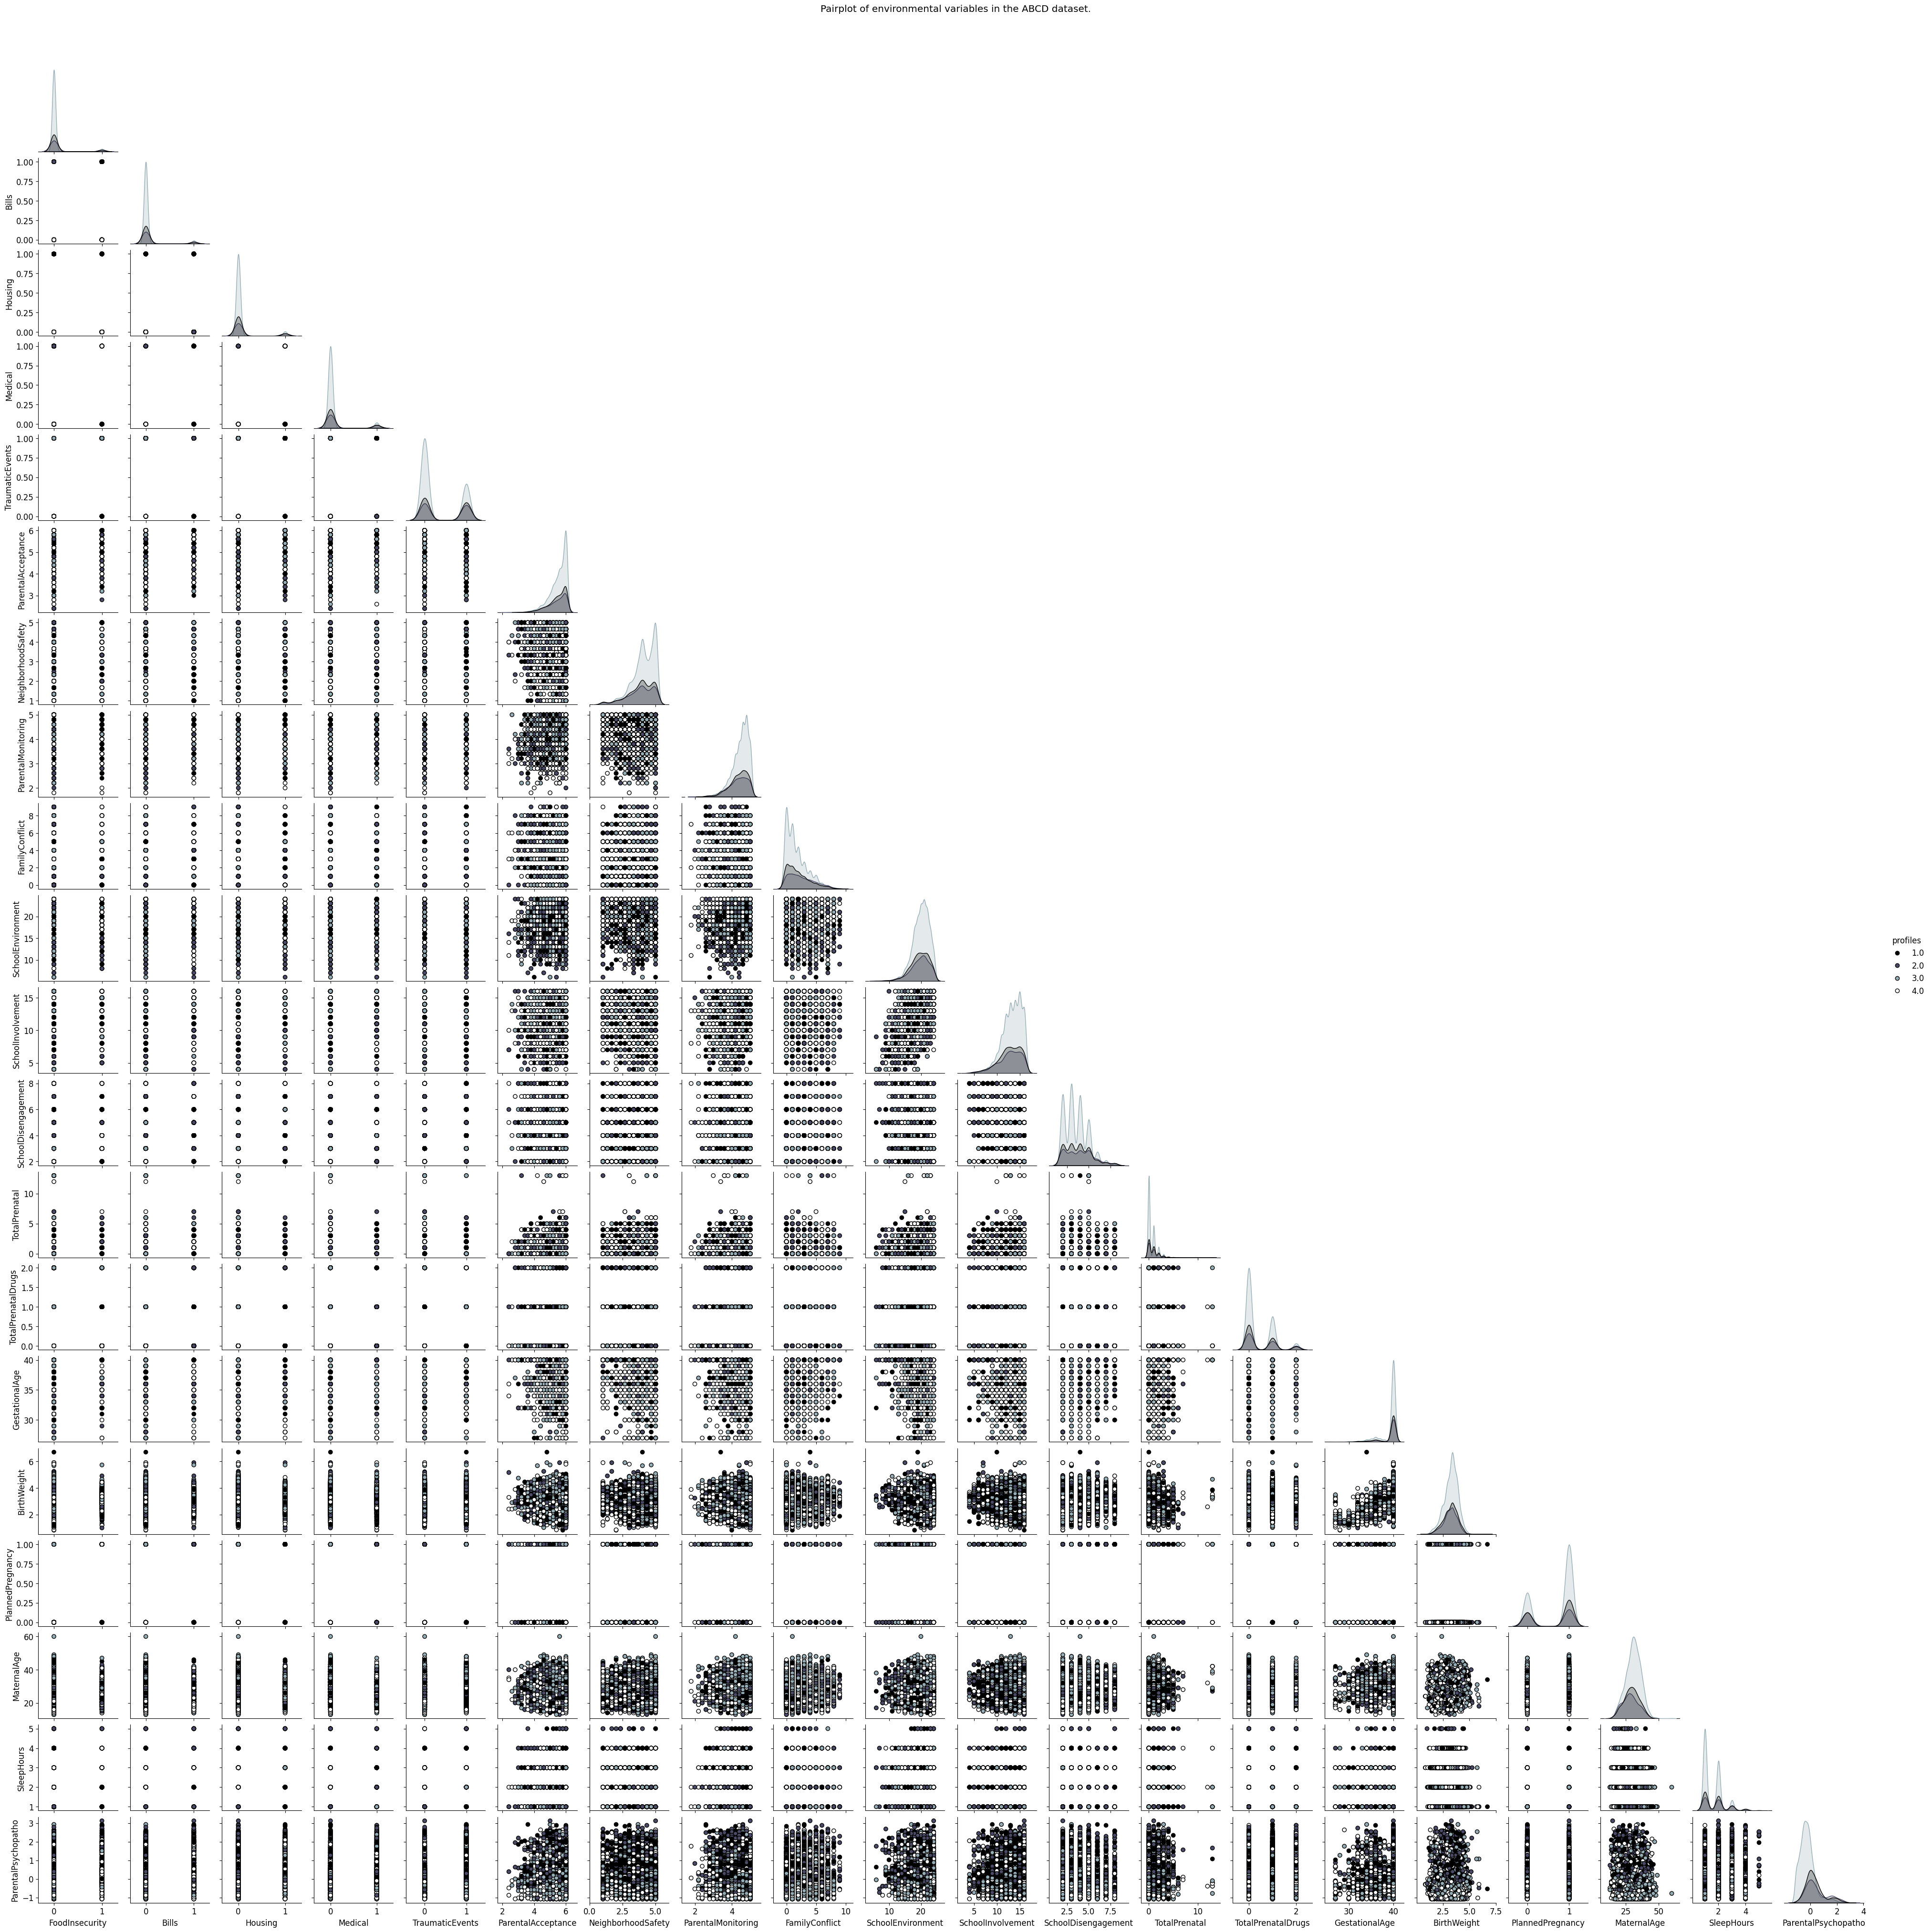

In [109]:
# Plot distribution and correlation of the environmental variables using a pairplot.
vars = ['FoodInsecurity', 'Bills', 'Housing', 'Medical', 'TraumaticEvents', 'ParentalAcceptance',
        'NeighborhoodSafety', 'ParentalMonitoring', 'FamilyConflict', 'SchoolEnvironment', 'SchoolInvolvement',
        'SchoolDisengagement', 'TotalPrenatal', 'TotalPrenatalDrugs', 'GestationalAge', 'BirthWeight', 'PlannedPregnancy',
        'MaternalAge', 'SleepHours', 'ParentalPsychopatho', 'profiles']

plotting_parameters = {
    'data': abcd_df[vars],
    'hue': 'profiles',
    'palette': 'bone',
    'corner': True,
    'diag_kind': 'kde',
    'plot_kws': {'edgecolor': 'k', 'linewidth': 1},
    'height': 2,
    'aspect': 1,
    'markers': 'o'
}

with plt.rc_context(
        {"font.family": "Sans Serif",
         "font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    pairplot = sns.pairplot(**plotting_parameters)
    pairplot.fig.suptitle('Pairplot of environmental variables in the ABCD dataset.', y=1.02)
    plt.show()

#### **Performing Partial Least Square Regression analysis between environmental factors and profiles.**

Using the environmental factors as predictors and profiles as dependent variables, the next cells will run cross-validation to determine the appropriate number of componenents to use in Partial Least Square Regression (PLSR) (by selecting the number of components with the lowest Mean-Squared error) and, then, will perform permutation testing to assess the model and variables coefficient significance. 

**This is a long running process, go get a coffee!**

In [13]:
# Splitting the data into X (environmental variables) and y (profiles membership values).
vars = ['NeighborhoodSafety', 'ParentalAcceptance', 'ParentalMonitoring',
       'FamilyConflict', 'SchoolEnvironment', 'SchoolInvolvement',
       'SchoolDisengagement', 'FoodInsecurity', 'Bills', 'Housing', 'Medical',
       'TraumaticEvents', 'TotalPrenatal', 'TotalPrenatalDrugs',
       'GestationalAge', 'BirthWeight', 'PlannedPregnancy', 'MaternalAge',
       'ParentalPsychopatho', 'SleepHours', 'edu_groups']

X = abcd_df[vars]
y = abcd_df[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']]

# Scaling the data (only environmental variables) and log transform membership values.
X = scale(X)
y = y.apply(lambda x: np.log(x))
y = scale(y)

In [14]:
# Performing cross-validation.
plsr, mse, score_c, score_cv, rscore, mse_c, mse_cv = plsr_cv(
    X,
    y,
    X.shape[1],
    splits=10,
    processes=4, # CHANGE THIS TO THE NUMBER OF CORES AVAILABLE
    verbose=True
)

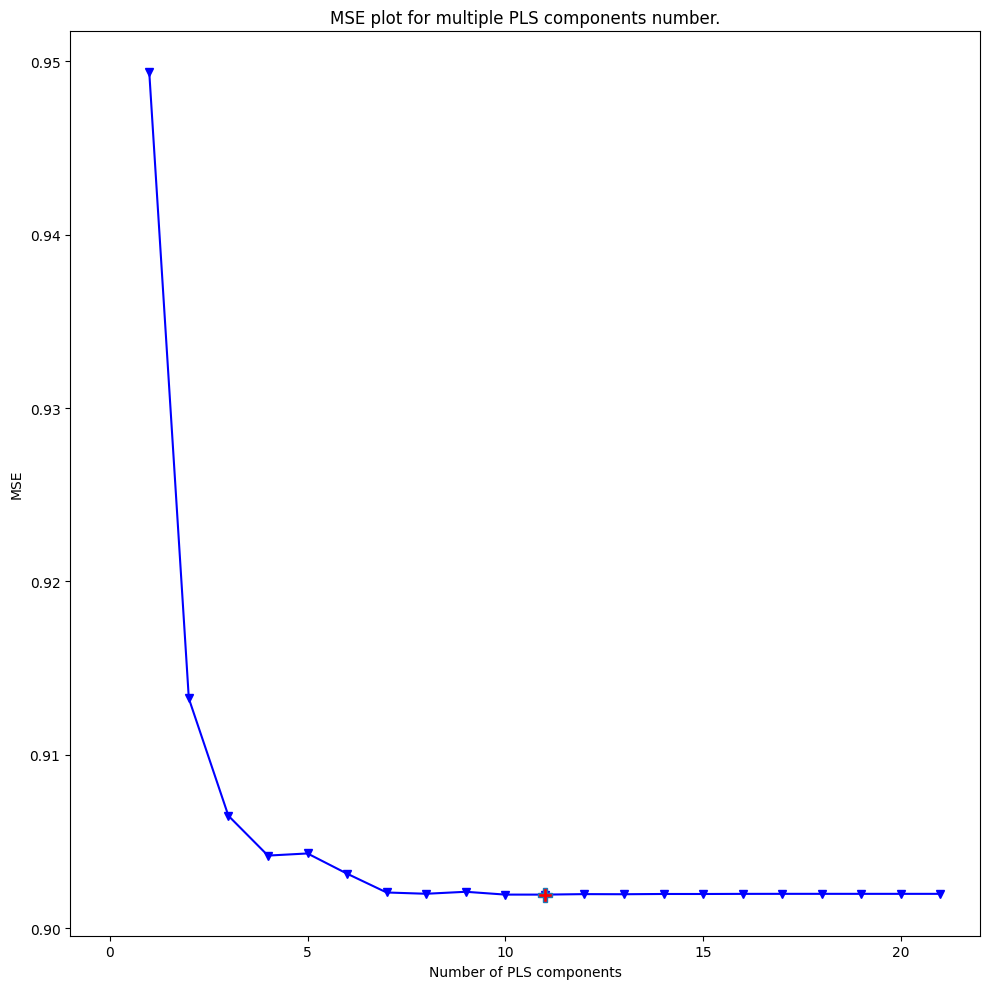

In [15]:
# MSE plot.
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(
    np.arange(1, X.shape[1]+1),
    np.array(mse),
    '-v',
    color='blue',
    mfc='blue')
plt.plot(
    np.arange(1, X.shape[1] + 1)[np.argmin(mse)],
    np.array(mse)[np.argmin(mse)],
    'P',
    ms=10,
    mfc='red')
plt.xlabel('Number of PLS components')
plt.ylabel('MSE')
plt.title('MSE plot for multiple PLS components number.')
plt.xlim(left=-1)
plt.tight_layout()
plt.show()

In [16]:
# Performing permutation testing.
mod, score, coef, perm_score, score_pval, perm_coef, coef_pval = permutation_testing(
    plsr,
    X,
    y,
    nb_permutations=10000,
    processes=6, # CHANGE THIS TO THE NUMBER OF CORES AVAILABLE
    verbose=True,
    scoring='r2',
    splits=10
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   19.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   39.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 10000 out of 10000 | elapsed: 12.8

In [57]:
# Exporting stats.
vars = ['NeighborhoodSafety', 'ParentalAcceptance', 'ParentalMonitoring',
       'FamilyConflict', 'SchoolEnvironment', 'SchoolInvolvement',
       'SchoolDisengagement', 'FoodInsecurity', 'Bills', 'Housing', 'Medical',
       'TraumaticEvents', 'TotalPrenatal', 'TotalPrenatalDrugs',
       'GestationalAge', 'BirthWeight', 'PlannedPregnancy', 'MaternalAge',
       'ParentalPsychopatho', 'SleepHours', 'ParentalEducation']

coef_val = {
    f'coef{i+1}': coef[:, i] for i in range(0, 4)}
coef_val['varname'] = vars
coef_df = pd.DataFrame(coef_val)
coef_df.to_excel(f'{output_dir}/ABCD_plsr_coef.xlsx', header=True,
                 index=False)

coef_pval_df = pd.DataFrame(coef_pval,
                            index=vars,
                            columns=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
# Control for False Discovery Rate.
coef_pval_corr = pd.DataFrame()
for col in coef_pval_df.columns:
    coef_pval_corr[f'{col}_fdr_corrected'] = false_discovery_control(coef_pval_df[col], method='bh')
coef_pval_corr.index = coef_pval_df.index

coef_pval_df.to_excel(f'{output_dir}/ABCD_plsr_coef_pval.xlsx', header=True,
                      index=True)
coef_pval_corr.to_excel(f'{output_dir}/ABCD_plsr_coef_pval_fdr_corrected.xlsx', header=True,
                        index=True)

stats = pd.DataFrame([mse_c, mse_cv, score_c, score_cv, rscore,
                        score, perm_score, score_pval],
                        columns=['Statistics'],
                        index=['MSE_c', 'MSE_cv', 'R2_c', 'R2_cv', 'R_c',
                            'R2_score', 'R2_perm', 'pval'])
stats.to_excel(f'{output_dir}/ABCD_plsr_stats.xlsx', header=True,
               index=True)

In [18]:
# Coefficient plot.
for i in range(0, y.shape[1]):
    generate_coef_plot(
        coef_df,
        coef_pval_corr.values[:, i],
        coefname=f'coef{i+1}',
        varname='varname',
        output=f'{output_dir}/ABCD_coef{i+1}.png'
    )

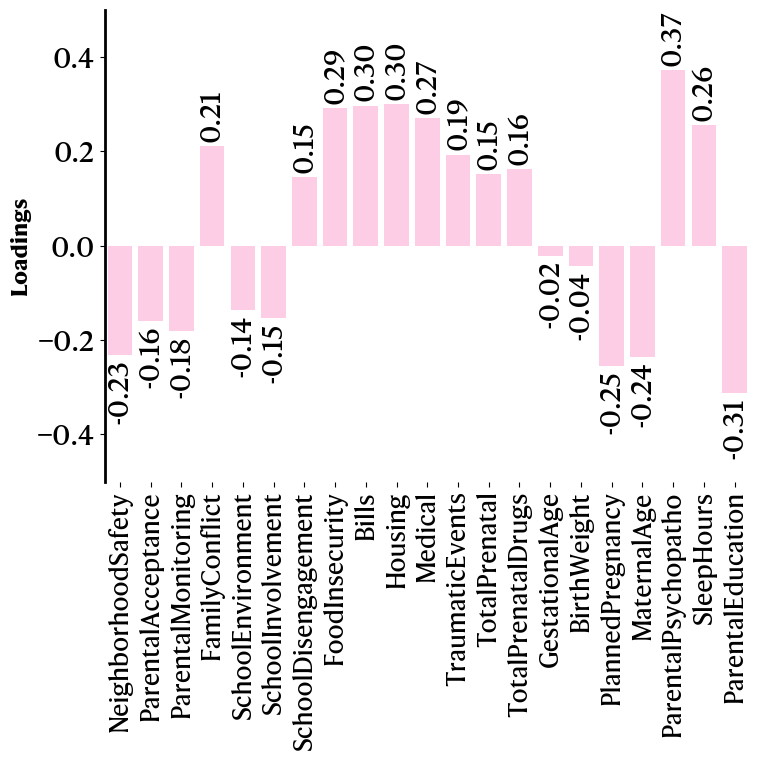

In [34]:
# Plot X loadings.
x_loadings = pd.DataFrame(plsr.x_loadings_, index=vars,
             columns=[f'Component {i+1}' for i in range(plsr.n_components)])
x_loadings.loc[:, 'varname'] = coef_df['varname'].values

# Fetch the seventh color from the Set2 palette.
color = sns.color_palette("Set3")[7]

plotting_parameters = {
    'data': x_loadings,
    'x': 'varname',
    'y': 'Component 1',
    'color': color,
    'saturation': 1,
    'orient': 'v', 
}
with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(8, 8))
    bar = sns.barplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left"]].set(linewidth=2)
    ax.spines[["bottom", "top", "right"]].set_visible(False)
    ax.set_ylabel("Loadings", fontdict={"fontweight": "bold", "fontsize": 16})
    ax.set_xlabel("", fontdict={"fontweight": "bold"})
    ax.set_xticklabels(vars, rotation=90, ha='right')
    
    ax.figure.autofmt_xdate(rotation=90, ha="center")
    plt.xticks(fontsize=18, fontweight='normal')
    ax.set_ylim(-0.5, 0.5)

    for bars in ax.containers:
        ax.bar_label(bars, fmt='{:,.2f}', padding=3, size=20, rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/ABCD_env_loadings.png', dpi=900)
    plt.show()

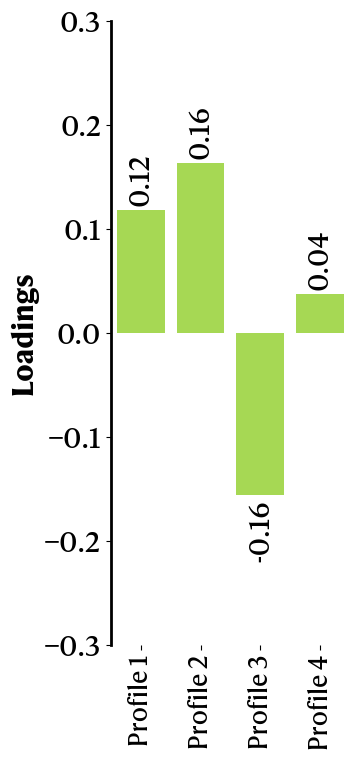

In [32]:
# Plot y loadings.
y_loadings = pd.DataFrame(plsr.y_loadings_, index=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
             columns=[f'Component {i+1}' for i in range(plsr.n_components)])
y_loadings.loc[:, 'varname'] = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Fetch the fifth color from the Set2 palette.
color = sns.color_palette("Set2")[4]

plotting_parameters = {
    'data': y_loadings,
    'x': 'varname',
    'y': 'Component 1',
    'color': color,
    'saturation': 1,
    'orient': 'v', 
}
with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(4, 8))
    bar = sns.barplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left"]].set(linewidth=2)
    ax.spines[["right", "bottom", "top"]].set_visible(False)
    ax.set_ylabel("Loadings", fontdict={"fontweight": "bold", "fontsize": 20})
    ax.set_xlabel("", fontdict={"fontweight": "bold"})
    ax.set_xticklabels(["Profile 1", "Profile 2", "Profile 3", "Profile 4"], rotation=90, ha='center')
    
    plt.xticks(fontsize=18, fontweight='normal')

    for bars in ax.containers:
        ax.bar_label(bars, fmt='{:,.2f}', padding=3, size=20, rotation=90)
    
    ax.set_ylim(-0.3, 0.3)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/ABCD_profile_loadings.png', dpi=900)
    plt.show()

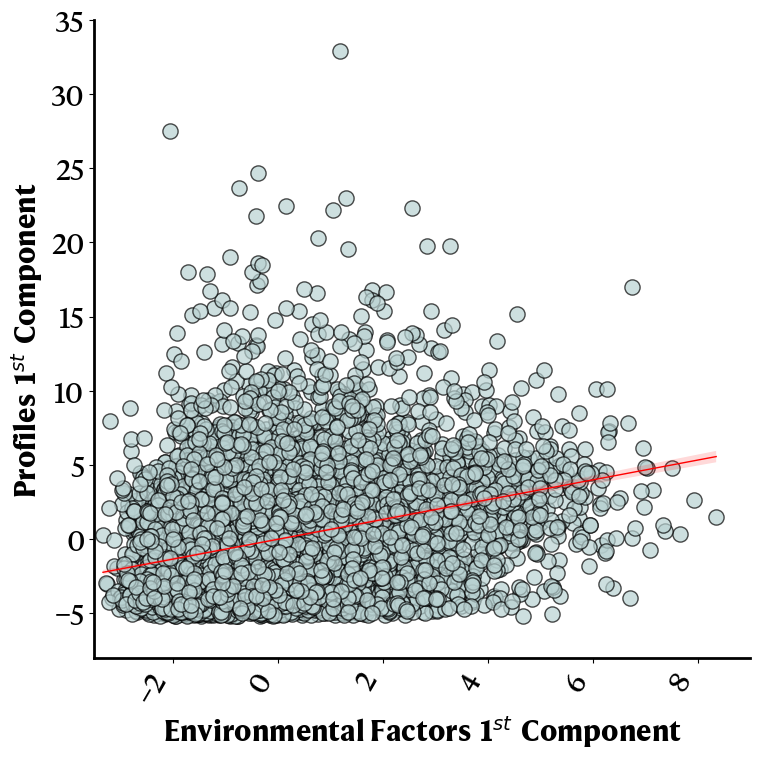

In [35]:
# Plot a scatter plot for the first pair of PLSR components.
x_data, y_data = mod.transform(X, y)

plotting_parameters = {
    'x': x_data[:, 0],
    'y': y_data[:, 0],
    'scatter_kws': {'edgecolor': 'k', 'alpha': 0.7,
                    "s": 120,
                    "color": plt.cm.bone(0.80)},
    'line_kws': {'linewidth': 1, 'color': 'r'},
}

with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = sns.regplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left", "bottom"]].set(linewidth=2)
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_ylabel("Profiles  1$^{st}$  Component", fontdict={"fontweight": "bold"})
    ax.set_xlabel("Environmental Factors  1$^{st}$  Component", fontdict={"fontweight": "bold"})
    ax.set_xlim(-3.5, 9)
    ax.set_ylim(-8, 35)
    
    ax.figure.autofmt_xdate(rotation=60, ha="right")
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/ABCD_plsr_scatter.png', dpi=900)
    plt.show()

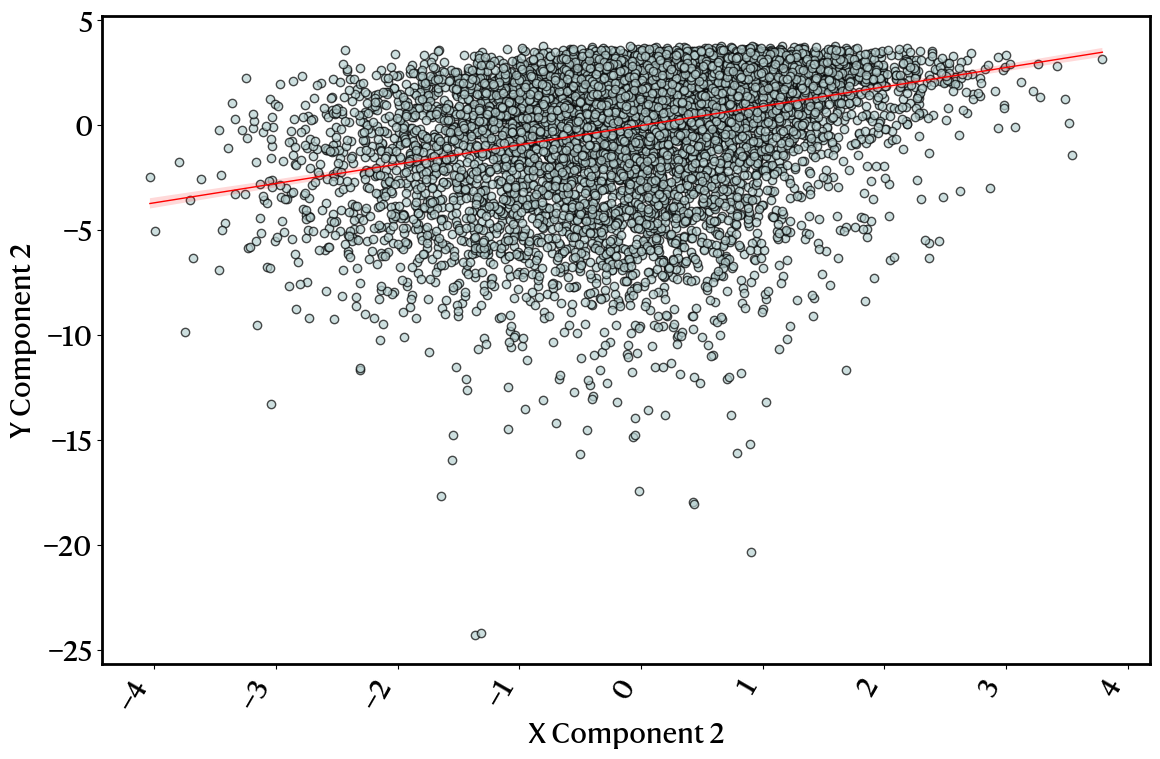

In [36]:
# Second components.
plotting_parameters = {
    'x': x_data[:, 1],
    'y': y_data[:, 1],
    'scatter_kws': {'edgecolor': 'k', 'alpha': 0.7,
                    "color": plt.cm.bone(0.80)},
    'line_kws': {'linewidth': 1, 'color': 'r'},
}

with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = sns.regplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left", "right", "bottom", "top"]].set(linewidth=2)
    ax.set_ylabel(f"Y Component 2")
    ax.set_xlabel(f"X Component 2")
    
    ax.figure.autofmt_xdate(rotation=60, ha="right")
    
    plt.tight_layout()
    plt.show()

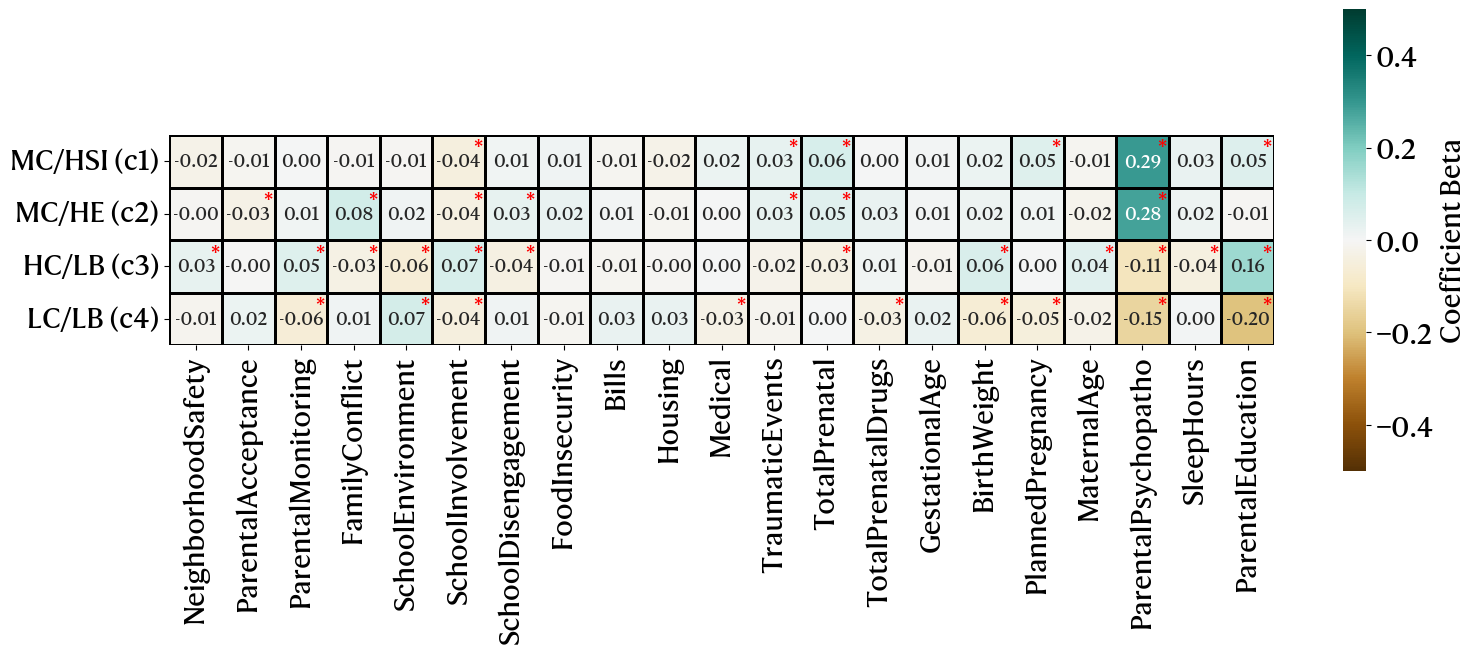

In [58]:
# Plot coefficient betas as a heatmap and annotate each cell with an asterisk if p-value < 0.05. Variables on the x-axis and profiles on the y-axis.
coef_df.set_index('varname', inplace=True)
coef_df.columns = ['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)']

plotting_parameters = {
        'data': coef_df.T,  
        'cmap': 'BrBG',
        'vmin': -0.5,
        'vmax': 0.5,
        'center': 0,
        'annot': True,
        'annot_kws': {'fontsize': 13},
        'fmt': '.2f',
        'robust': True,
        'linewidths': 1,
        'linecolor': 'black',
        'cbar_kws': {'label': 'Coefficient Beta', 'shrink':0.3},
        'square': True,
}

with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
        fig, ax = plt.subplots(figsize=(16, 16))
        heatmap = sns.heatmap(ax=ax, **plotting_parameters)

        ax.set_xlabel('')
        #ax.set_title('Heatmap of coefficient betas for each variable and profile.')

        # Annotate with asterix if p-value < 0.05.
        for i, j in product(range(coef_pval_corr.T.shape[0]), range(coef_pval_corr.T.shape[1])):
            if coef_pval_corr.T.values[i, j] < 0.05:
                ax.text(j + 0.95, i + 0.05, "*", ha='right', va='top', color='red', fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/ABCD_coef_heatmap.png', dpi=900)
        plt.show()


#### **Investigating the relationship between environmental factors and profiles in the GESTE cohort**.

The following section will perform a partial least square regression analysis between the cognitive/behavioral profiles and available environmental factors within the GESTE study. **Available environmental factors included were:**

1. Maternal Age at delivery
1. Gestational Age
1. Birth Weight
1. Traumatic Event
1. Prenatal Substance Use
1. Sleeping Hours
1. Parental Psychopathology
1. Prenatal Conditions.
1. Parental Education.

Results will be outputted in the above defined `output_dir` in the form of spreadsheets containing coefficients, p-values, and model statistics as well as in barplot illustrating the variables' coefficients for each profile. Other visualization are available directly in the notebook.

In [9]:
# Fetch environmental data.
env_df = load_df_in_any_format(f'{geste_base_dir}/PopInfo.csv')

In [10]:
# Extract only the needed columns.
env_df = env_df[['record_id', 'agedelivcalcul', 'ga_wks_bb', 'masse_bb', 'fume', 'alcool', 'drug', 'garde_enf',
       'eve_spec___0', 'eve_spec___1', 'eve_spec___2', 'eve_spec___3',
       'eve_spec___4', 'eve_spec___5', 'eve_spec___6', 'eve_spec___7',
       'eve_spec___8', 'eve_spec___9', 'eve_spec___10', 'eve_spec___11',
       'diag_gross___0', 'diag_gross___1', 'diag_gross___2', 'diag_gross___3',
       'diag_gross___4', 'diag_gross___5', 'diag_gross___6', 'diag_gross___7',
       'diag_gross___8', 'diag_gross___9', 'aucun_mere___1', 'aucun_mere___2',
       'aucun_mere___3', 'aucun_mere___4', 'aucun_mere___5', 'aucun_pere___1',
       'aucun_pere___2', 'aucun_pere___3', 'aucun_pere___4', 'aucun_pere___5',
       'heur_couch', 'heur_lev', 'bmi_child']]

In [11]:
#  Compute prenatal conditions (as the total of the prenatal conditions variables).
def compute_ACE_conditions(row):
    if row['eve_spec___0'] == 1:
        return 0
    elif row['eve_spec___1'] == 1 or row['eve_spec___2'] == 1 or row['eve_spec___3'] == 1 or row['eve_spec___4'] == 1 or row['eve_spec___5'] == 1 or row['eve_spec___6'] == 1 or row['eve_spec___7'] == 1 or row['eve_spec___8'] == 1 or row['eve_spec___9'] == 1 or row['eve_spec___10'] == 1 or row['eve_spec___11'] == 1:
        return 1
    else: 
        ValueError("No traumatic event found.")

env_df.loc[:, 'traumatic_event'] = env_df.apply(compute_ACE_conditions, axis=1)

# Code prenatal substance use.
def code_prenatal_substance_use(row):
    if row['fume'] == 1 or row['alcool'] == 1 or row['drug'] == 1:
        return 1
    elif row['fume'] == 0 and row['alcool'] == 0 and row['drug'] == 0:
        return 0
    else:
        ValueError("No prenatal substance use found.")

env_df.loc[:, 'prenatal_substance_use'] = env_df.apply(code_prenatal_substance_use, axis=1)

# Compute sleeping hours.
def recode_night_hours(row):
    if row['heur_couch'] == 1:
        return 19
    elif row['heur_couch'] == 2:
        return 20
    elif row['heur_couch'] == 3:
        return 21
    elif row['heur_couch'] == 4:
        return 22
    elif row['heur_couch'] == 5:
        return 23

def recode_morning_hours(row):
    if row["heur_lev"] == 1:
        return 24 + 5
    elif row["heur_lev"] == 2:
        return 24 + 6
    elif row["heur_lev"] == 3:
        return 24 + 7
    elif row["heur_lev"] == 4:
        return 24 + 8

env_df.loc[:, 'heur_couch'] = env_df.apply(recode_night_hours, axis=1)
env_df.loc[:, 'heur_lev'] = env_df.apply(recode_morning_hours, axis=1)
env_df.loc[:, 'sleeping_hours'] = env_df['heur_lev'] - env_df['heur_couch']

# Compute parental psychopathology.
def compute_parental_psychopatho(row):
    if row['aucun_mere___1'] == 1 or row['aucun_mere___2'] == 1 or row['aucun_mere___3'] == 1 or row['aucun_mere___4'] == 1 or row['aucun_mere___5'] == 1:
        return 0
    elif row['aucun_pere___1'] == 1 or row['aucun_pere___2'] == 1 or row['aucun_pere___3'] == 1 or row['aucun_pere___4'] == 1 or row['aucun_pere___5'] == 1:
        return 0
    else:
        return 1

env_df.loc[:, 'parental_psychopatho'] = env_df.apply(compute_parental_psychopatho, axis=1)

# Compute prenatal conditions.
def compute_prenatal_conditions(row):
    if row['diag_gross___0'] == 1:
        return 0
    else:
        return row.diag_gross___1 + row.diag_gross___2 + row.diag_gross___3 + row.diag_gross___4 + row.diag_gross___5 + row.diag_gross___6 + row.diag_gross___7 + row.diag_gross___8 + row.diag_gross___9

env_df.loc[:, 'prenatal_conditions'] = env_df.apply(compute_prenatal_conditions, axis=1)

# Drop the unnecessary columns.
env_df = env_df[['record_id', 'agedelivcalcul', 'ga_wks_bb', 'masse_bb', 'bmi_child', 'traumatic_event', 'prenatal_substance_use', 'sleeping_hours', 'parental_psychopatho', 'prenatal_conditions']]
env_df.columns = ['subjectkey', 'Age delivery', 'Gestational Age', 'Birth weight', 'BMI', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions']

In [12]:
# Merging attributes with edge data.
# Sanity check to make sure the subjectkey is the same in both datasets.
assert (attributes_df.index == edges_df.index).all(), "Subjectkey is not the same in both datasets."

geste_df = pd.concat([attributes_df, edges_df], axis=1)
geste_df = geste_df[geste_df['cohort'] == 3]
geste_df.reset_index(inplace=True, drop=False, names='subjectkey')

# Merge the environmental data with the GESTE data.
geste_df = merge_dataframes({'geste_df': geste_df, 'env_df': env_df}, index='subjectkey')

# Cleaning NaN from variable of interest.
geste_df.dropna(subset=['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'edu_groups'], inplace=True)

In [13]:
print('Number of subjects in the GESTE dataset:', geste_df.shape[0])

Number of subjects in the GESTE dataset: 216


In [14]:
# PLSR between environmental variables and profiles membership values.
# Splitting the data into X (environmental variables) and y (profiles membership values).

X = geste_df[['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'edu_groups']]
X.columns = ['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'Parental education']
y = geste_df[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']]

# Scaling the data (only environmental variables) and log transform membership values.
X = scale(X)
y = y.apply(lambda x: np.log(x))
y = scale(y)

In [15]:
# Perform cross-validation.
plsr, mse, score_c, score_cv, rscore, mse_c, mse_cv = plsr_cv(
    X,
    y,
    X.shape[1],
    splits=10,
    processes=1,
    verbose=True
)

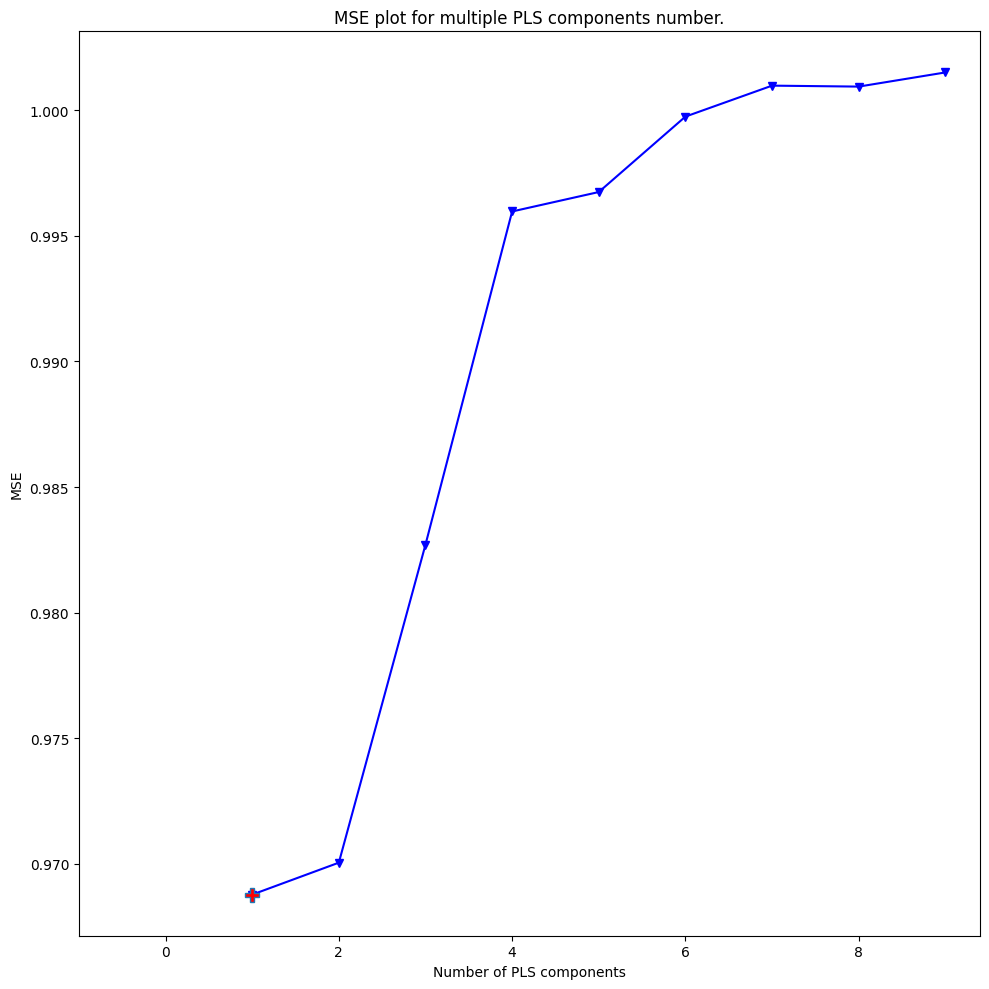

In [16]:
# MSE plot.
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(
    np.arange(1, X.shape[1]+1),
    np.array(mse),
    '-v',
    color='blue',
    mfc='blue')
plt.plot(
    np.arange(1, X.shape[1] + 1)[np.argmin(mse)],
    np.array(mse)[np.argmin(mse)],
    'P',
    ms=10,
    mfc='red')
plt.xlabel('Number of PLS components')
plt.ylabel('MSE')
plt.title('MSE plot for multiple PLS components number.')
plt.xlim(left=-1)
plt.tight_layout()
plt.show()

In [17]:
# Perform permutation testing.
mod, score, coef, perm_score, score_pval, perm_coef, coef_pval = permutation_testing(
    plsr,
    X,
    y,
    nb_permutations=10000,
    processes=4,
    verbose=True,
    scoring='r2',
    splits=10
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 4492 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:   18.8s finished


In [30]:
# Exporting stats.
coef_val = {
    f'coef{i+1}': coef[:, i] for i in range(0, 4)}
coef_val['varname'] = ['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'Parental education']
coef_df = pd.DataFrame(coef_val)
coef_df.to_excel(f'{output_dir}/GESTE_plsr_coef.xlsx', header=True,
                 index=False)

coef_pval_df = pd.DataFrame(coef_pval,
                            index=['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'Parental education'],
                            columns=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

# Control for False Discovery Rate.
coef_pval_corr = pd.DataFrame()
for col in coef_pval_df.columns:
    coef_pval_corr[col] = false_discovery_control(coef_pval_df[col], method='bh')
coef_pval_corr.set_index(coef_pval_df.index)

coef_pval_df.to_excel(f'{output_dir}/GESTE_plsr_coef_pval.xlsx', header=True,
                      index=True)
coef_pval_corr.to_excel(f'{output_dir}/GESTE_plsr_coef_pval_fdr_corrected.xlsx', header=True,
                        index=True)

stats = pd.DataFrame([mse_c, mse_cv, score_c, score_cv, rscore,
                        score, perm_score, score_pval],
                        columns=['Statistics'],
                        index=['MSE_c', 'MSE_cv', 'R2_c', 'R2_cv', 'R_c',
                            'R2_score', 'R2_perm', 'pval'])
stats.to_excel(f'{output_dir}/GESTE_plsr_stats.xlsx', header=True,
               index=True)

In [19]:
# Coefficient plot.
for i in range(0, y.shape[1]):
    generate_coef_plot(
        coef_df,
        coef_pval_corr.values[:, i],
        coefname=f'coef{i+1}',
        varname='varname',
        output=f'{output_dir}/GESTE_coef{i+1}.png'
    )

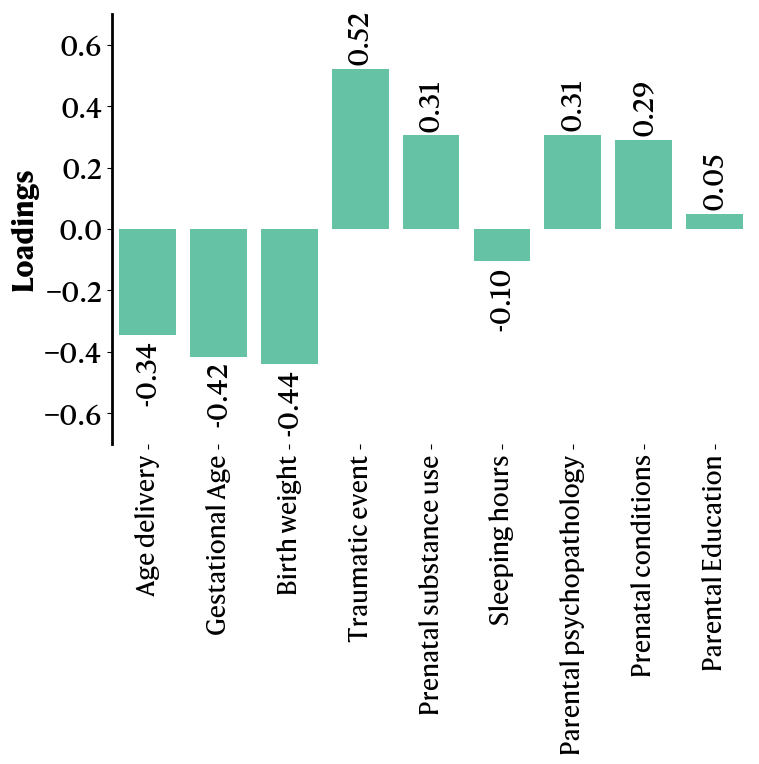

In [20]:
# Plot X loadings.
x_loadings = pd.DataFrame(plsr.x_loadings_, index=['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'edu_groups'],
             columns=['Component 1'])
x_loadings.loc[:, 'varname'] = coef_df['varname'].values

# Fetch the first color of the Set2 palette.
color = sns.color_palette("Set2")[0]

plotting_parameters = {
    'data': x_loadings,
    'x': 'varname',
    'y': 'Component 1',
    'color': color,
    'saturation': 1,
    'orient': 'v', 
}
with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(8, 8))
    bar = sns.barplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left"]].set(linewidth=2)
    ax.spines[["right", "bottom", "top"]].set_visible(False)
    ax.set_ylabel("Loadings", fontdict={"fontweight": "bold", "fontsize": 20})
    ax.set_xlabel("", fontdict={"fontweight": "bold"})
    ax.set_xticklabels(['Age delivery', 'Gestational Age', 'Birth weight', 'Traumatic event', 'Prenatal substance use', 'Sleeping hours', 'Parental psychopathology', 'Prenatal conditions', 'Parental Education'])
    
    ax.figure.autofmt_xdate(rotation=90, ha="center")
    plt.xticks(fontsize=18, fontweight='normal')
    ax.set_ylim(-0.7, 0.7)
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='{:,.2f}', padding=3, size=20, rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/GESTE_env_loadings.png', dpi=900)
    plt.show()

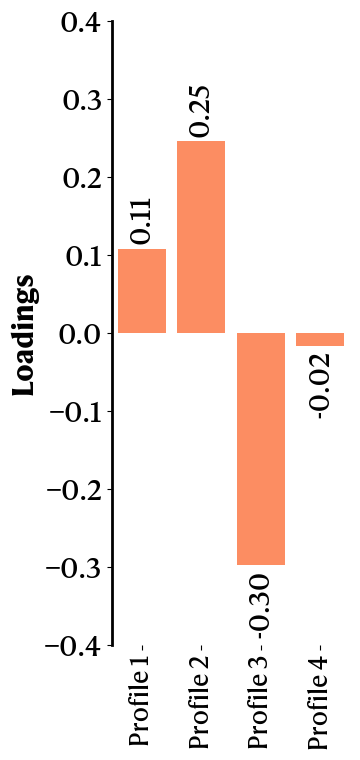

In [22]:
# Plot y loadings.
y_loadings = pd.DataFrame(plsr.y_loadings_, index=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
             columns=['Component 1'])
y_loadings.loc[:, 'varname'] = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Fetch second color of the Set2 palette.
color = sns.color_palette("Set2")[1]

plotting_parameters = {
    'data': y_loadings,
    'x': 'varname',
    'y': 'Component 1',
    'color': color,
    'saturation': 1,
    'orient': 'v', 
}
with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(4, 8))
    bar = sns.barplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left"]].set(linewidth=2)
    ax.spines[["right", "bottom", "top"]].set_visible(False)
    ax.set_ylabel("Loadings", fontdict={"fontweight": "bold", "fontsize": 20})
    ax.set_xlabel("", fontdict={"fontweight": "bold"})
    ax.set_xticklabels(["Profile 1", "Profile 2", "Profile 3", "Profile 4"],
                       rotation=90, ha='center')
    
    plt.xticks(fontsize=18, fontweight='normal')
    ax.set_ylim(-0.4, 0.4)
    
    for bars in ax.containers:
        ax.bar_label(bars, fmt='{:,.2f}', padding=3, size=20, rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/GESTE_profile_loadings.png', dpi=900)
    plt.show()

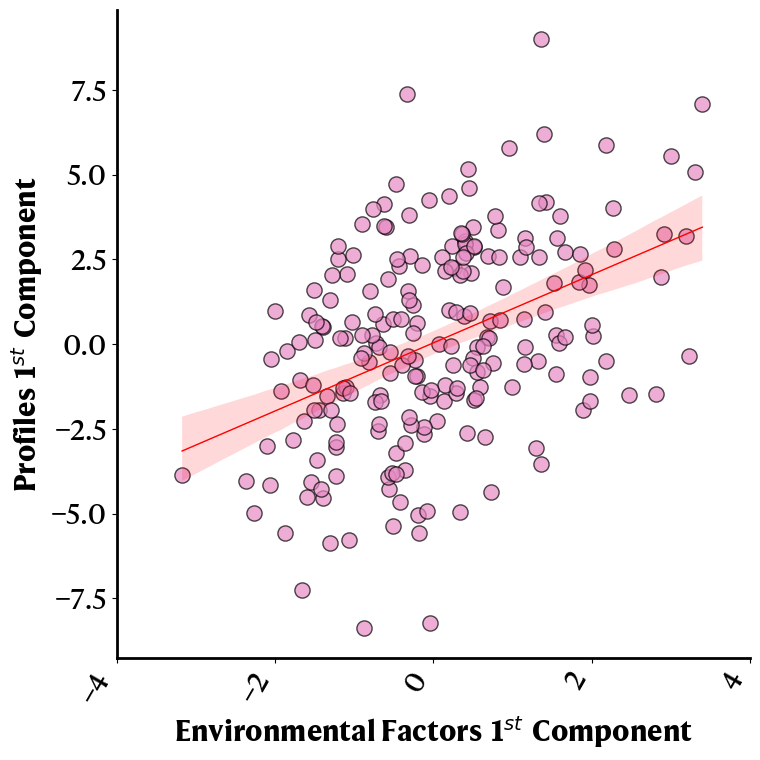

In [93]:
# Plot a scatter plot for the first pair of PLSR components.
x_data, y_data = mod.transform(X, y)

# Fetch 4th color of the Set2 palette.
color = sns.color_palette("Set2")[3]

plotting_parameters = {
    'x': x_data[:, 0],
    'y': y_data[:, 0],
    'scatter_kws': {'edgecolor': 'k', 'alpha': 0.7,
                    "s": 120,
                    "color": color},
    'line_kws': {'linewidth': 1, 'color': 'r'},
}

with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 20, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = sns.regplot(ax=ax, **plotting_parameters)
    
    ax.spines[["left", "bottom"]].set(linewidth=2)
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_ylabel("Profiles  1$^{st}$  Component", fontdict={"fontweight": "bold"})
    ax.set_xlabel("Environmental Factors  1$^{st}$  Component", fontdict={"fontweight": "bold"})
    ax.set_xlim(-4, 4)
    
    ax.figure.autofmt_xdate(rotation=60, ha="right")
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/GESTE_plsr_scatter.png', dpi=900)
    plt.show()

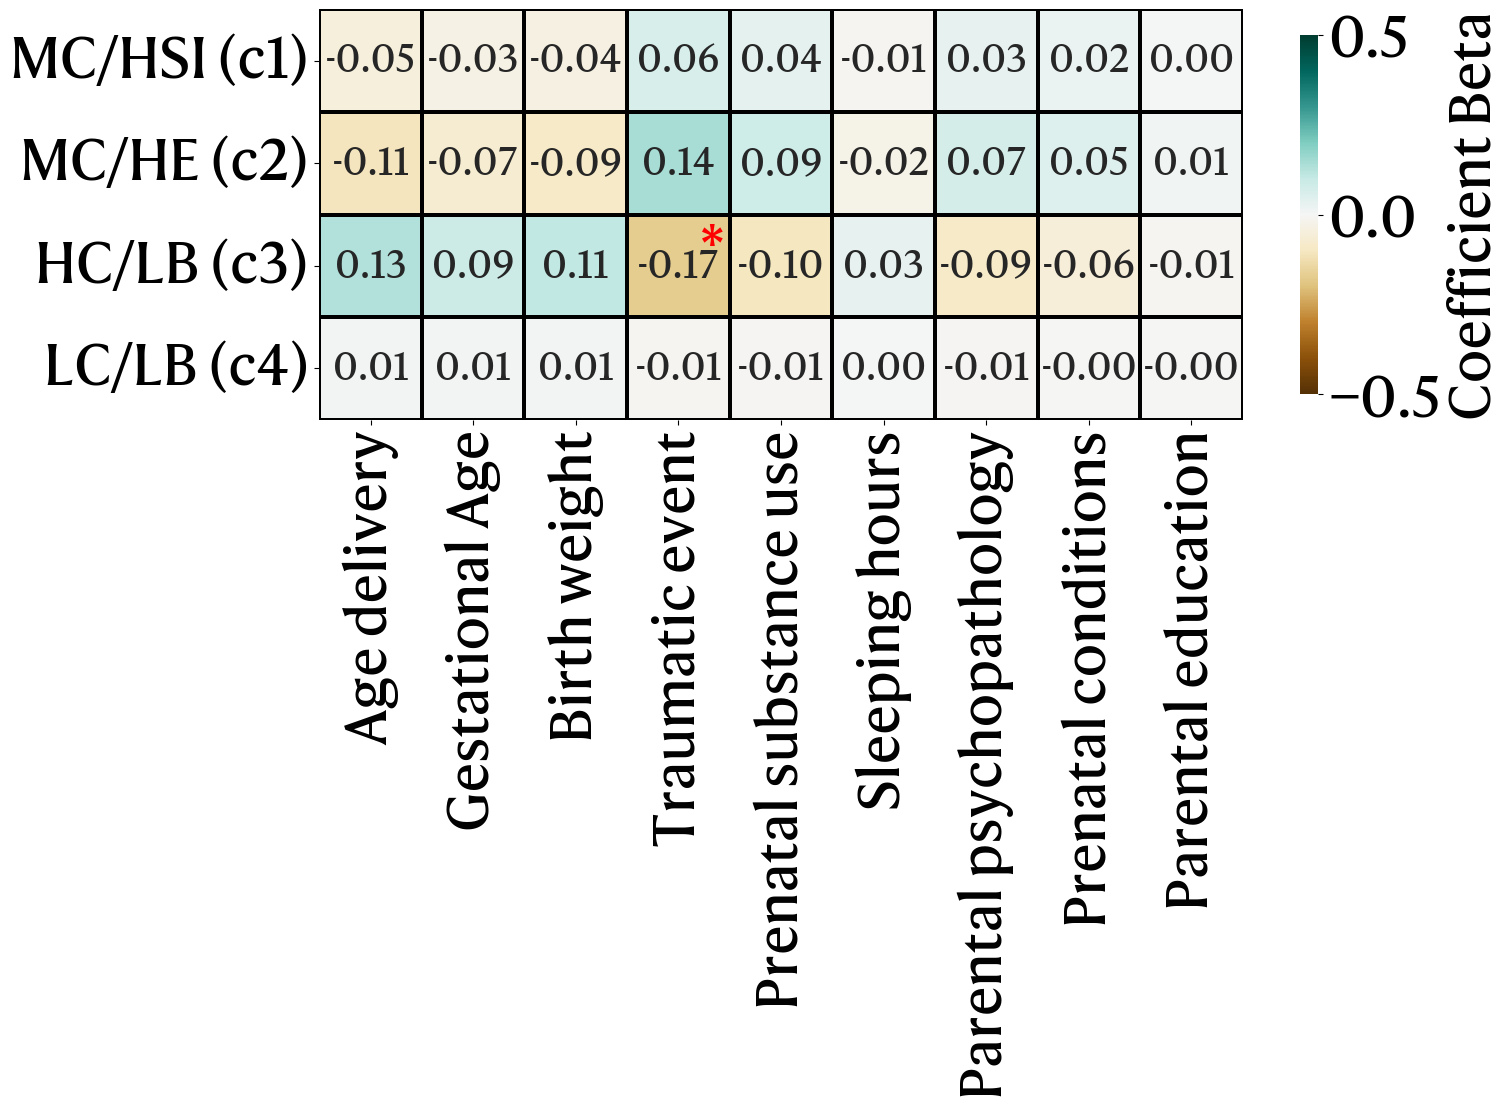

In [31]:
# Plot coefficient betas as a heatmap and annotate each cell with an asterisk if p-value < 0.05. Variables on the x-axis and profiles on the y-axis.
coef_df.set_index('varname', inplace=True)
coef_df.columns = ['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)']

plotting_parameters = {
        'data': coef_df.T,  
        'cmap': 'BrBG',
        'vmin': -0.5,
        'vmax': 0.5,
        'center': 0,
        'annot': True,
        'annot_kws': {'fontsize': 27},
        'fmt': '.2f',
        'robust': True,
        'linewidths': 1.5,
        'linecolor': 'black',
        'cbar_kws': {'label': 'Coefficient Beta', 'shrink':0.3},
        'square': True,
}

with plt.rc_context(
        {"font.family": "Harding Text Web",
         "font.size": 40, "font.weight": "normal", "axes.titleweight": "bold",
         }
    ):
        fig, ax = plt.subplots(figsize=(16, 16))
        heatmap = sns.heatmap(ax=ax, **plotting_parameters)

        ax.set_xlabel('')
        #ax.set_title('Heatmap of coefficient betas for each variable and profile.')

        # Annotate with asterix if p-value < 0.05.
        for i, j in product(range(coef_pval_corr.T.shape[0]), range(coef_pval_corr.T.shape[1])):
            if coef_pval_corr.T.values[i, j] < 0.05:
                ax.text(j + 0.95, i + 0.05, "*", ha='right', va='top', color='red', fontsize=48)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/GESTE_coef_heatmap.png', dpi=900)
        plt.show()